In [1]:
from fmm import Network,NetworkGraph,FastMapMatch,FastMapMatchConfig,UBODT
import pandas as pd
from shapely.wkt import loads
from shapely.geometry import LineString
import tracers as tr
import numpy as np
import os
import json
import statistics

#load network data and graph 
network = Network("../osmnx_example/rome/edges.shp","fid", "u", "v")
print("Nodes {} edges {}".format(network.get_node_count(),network.get_edge_count()))
graph = NetworkGraph(network)

[2025-03-19 16:39:33.048] [info] [network.cpp:72] Read network from file ../osmnx_example/rome/edges.shp
[2025-03-19 16:39:34.849] [info] [network.cpp:172] Number of edges 188608 nodes 88690
[2025-03-19 16:39:34.849] [info] [network.cpp:173] Field index: id 20 source 0 target 1
[2025-03-19 16:39:35.042] [info] [network.cpp:176] Read network done.
Nodes 88690 edges 188608
[2025-03-19 16:39:35.044] [info] [network_graph.cpp:17] Construct graph from network edges start
[2025-03-19 16:39:35.078] [info] [network_graph.cpp:30] Graph nodes 88690 edges 188608
[2025-03-19 16:39:35.078] [info] [network_graph.cpp:31] Construct graph from network edges end


In [2]:
ubodt = UBODT.read_ubodt_csv("../osmnx_example/rome/ubodt.txt")

[2025-03-19 16:39:35.094] [info] [ubodt.cpp:208] Reading UBODT file (CSV format) from ../osmnx_example/rome/ubodt.txt
[2025-03-19 16:39:36.031] [info] [ubodt.cpp:236] Read rows 1000000
[2025-03-19 16:39:36.913] [info] [ubodt.cpp:236] Read rows 2000000
[2025-03-19 16:39:37.726] [info] [ubodt.cpp:236] Read rows 3000000
[2025-03-19 16:39:38.553] [info] [ubodt.cpp:236] Read rows 4000000
[2025-03-19 16:39:39.449] [info] [ubodt.cpp:236] Read rows 5000000
[2025-03-19 16:39:40.366] [info] [ubodt.cpp:236] Read rows 6000000
[2025-03-19 16:39:41.230] [info] [ubodt.cpp:236] Read rows 7000000
[2025-03-19 16:39:42.078] [info] [ubodt.cpp:236] Read rows 8000000
[2025-03-19 16:39:42.883] [info] [ubodt.cpp:236] Read rows 9000000
[2025-03-19 16:39:43.754] [info] [ubodt.cpp:236] Read rows 10000000
[2025-03-19 16:39:44.570] [info] [ubodt.cpp:236] Read rows 11000000
[2025-03-19 16:39:45.462] [info] [ubodt.cpp:236] Read rows 12000000
[2025-03-19 16:39:46.288] [info] [ubodt.cpp:236] Read rows 13000000
[2025-0

In [6]:
with open('datapath.json', 'r') as f:
    data = json.load(f)

root_path = data['data_path']

METER_PER_DEGREE = 109662.80313373724

# these users wont give an empty mm result for the last 2000 points

total_precision = []
total_recall = []
total_f1 = []
total_accuracy = []
ep_list = []
tp_list = []
error_list = []
best_ep_list = []
best_tp_list = []
best_error_list =[]
best_sp_dist_list = []
sp_dist_list = []

valid_users = 0

for user_id in range(290,305):
    user_path = f'taxi_{user_id}'
    folder_path = os.path.join(root_path, user_path)

    if not os.path.exists(folder_path):
        print("folder path not found")
        continue
    
    for file in os.scandir(folder_path): 
        df = pd.read_csv(file, sep=",")
        df = df.rename(columns={"ID": "id", "Latitude": "x", "Longitude": "y", "Timestamp": "timestamp"})

        # Convert timestamp to epoch and sort by timestamp
        df["timestamp"] = pd.to_datetime(df["timestamp"], format="ISO8601", errors="coerce").astype(int) / 10**9
        df["timestamp"] = df["timestamp"].astype(int)
        df = df.sort_values(by="timestamp")

        # Create wkt from lat lon data
        original_linestring = LineString(zip(df["y"], df["x"]))
        original_wkt = original_linestring.wkt
        model = FastMapMatch(network, graph, ubodt)

        # Configuration params
        k = 20
        radius = 400 / METER_PER_DEGREE
        gps_error = 10 / METER_PER_DEGREE

        fmm_config = FastMapMatchConfig(k, radius, gps_error, perturbation=False, reverse_tolerance=0.2)

        # mm on the original trajectory 
        result = model.match_wkt(original_wkt, fmm_config)

        if result.cpath: 
            print(f"Map matching succeeded for user {user_id}") 
            gt_wkt = result.mgeom.export_wkt()

            try:
                gt = loads(gt_wkt)
            
                # Ensure it's a valid LineString with more than one point
                if gt.geom_type != "LineString" or len(gt.coords) < 2:
                    print(f"Skipping user {user_id}, invalid LineString: {wkt_result}")
                    continue

            except Exception as e:
                print(f"Skipping user {user_id}, error loading WKT: {e}")
                continue 

            # Apply perturbation
            (space_noise, time_min_period) = (20.0, 30)
            trace = df[['y', 'x', 'timestamp']].to_numpy()
            trace = [tuple(x) for x in trace]
            trace = [(x[0], x[1], int(x[2])) for x in trace]

            perturbed_traces = tr.perturb_traces((space_noise, time_min_period), [trace], picker_str='closest')
            perturbed_trace = perturbed_traces[0]

            df_pert = pd.DataFrame(perturbed_trace, columns=["y", "x", "timestamp"])
            df_pert["id"] = df["id"].iloc[0]

            perturbed_linestring = LineString(zip(df_pert["y"], df_pert["x"]))
            perturbed_wkt = perturbed_linestring.wkt

            obfuscation_stdev = 20

            fmm_config_pert = FastMapMatchConfig(30, radius, obfuscation_stdev, perturbation=True, reverse_tolerance=0.2)
            result_pert = model.match_wkt(perturbed_wkt, fmm_config_pert)

            if result_pert.cpath: 
                wkt_result = result_pert.mgeom.export_wkt()

                try:
                    perturbed_geom = loads(wkt_result)
                    
                    # Ensure it's a valid LineString with more than one point
                    if perturbed_geom.geom_type != "LineString" or len(perturbed_geom.coords) < 2:
                        print(f"Skipping user {user_id}, invalid LineString: {wkt_result}")
                        continue

                except Exception as e:
                    print(f"Skipping user {user_id}, error loading WKT: {e}")
                    continue

                # Calculate intersection length between GT and perturbed matched result
                intersection = gt.intersection(perturbed_geom).length
                gt_length = gt.length
                mm_length = perturbed_geom.length

                if mm_length > 0 and gt_length > 0:  
                    precision = intersection / mm_length
                    recall = intersection / gt_length
                    f1 = (2 * precision * recall) / (precision + recall) if (precision+recall)>0 else 0
                    accuracy = intersection / max(mm_length, gt_length)

                    print(f"user {user_id}, F1: {f1}")

                    total_precision.append(precision)
                    total_recall.append(recall)
                    total_f1.append(f1)
                    total_accuracy.append((accuracy,gt_length))

                    if(accuracy < 0.5):
                        candidates = result_pert.candidates
                        for candidate in candidates:
                            best_ep_list.append(candidate.ep)
                            best_tp_list.append(candidate.tp)
                            best_sp_dist_list.append(candidate.spdist)
                            best_error_list.append(candidate.error)
                
                candidates = result_pert.candidates
                for candidate in candidates:
                    ep_list.append(candidate.ep)
                    tp_list.append(candidate.ep)
                    sp_dist_list.append(candidate.spdist)
                    error_list.append(candidate.error)
                
            
                valid_users += 1

# precision, recall and f1
if valid_users > 0:
    med_precision = statistics.median(total_precision)  
    med_recall = statistics.median(total_recall)        
    med_f1 = statistics.median(total_f1)
    weighted_acc = sum(acc * length for acc, length in total_accuracy) / sum(length for _, length in total_accuracy)

    print(f"Valid traces: {valid_users}")
    print(f"Median Precision: {med_precision}")
    print(f"Median Recall: {med_recall}")
    print(f"Median F1 Score: {med_f1}")
    print(f"Accuracy by length: {weighted_acc}")
else:
    print("map matching failed for all users")

Map matching succeeded for user 290
user 290, F1: 0.6447423677104348
Map matching succeeded for user 290
user 290, F1: 0.8608570757648445
Map matching succeeded for user 290
user 290, F1: 0.8392072388762027
Map matching succeeded for user 290
user 290, F1: 0.7646152841726481
Map matching succeeded for user 290
user 290, F1: 0.7657689646818878
Map matching succeeded for user 290
user 290, F1: 0.6764814295423827
Map matching succeeded for user 290
user 290, F1: 0.6508214120183601
Map matching succeeded for user 290
user 290, F1: 0.7666643258380004
Map matching succeeded for user 290
user 290, F1: 0.7423214387982644
Map matching succeeded for user 290
user 290, F1: 0.8835310500918052
Map matching succeeded for user 290
user 290, F1: 0.7430469049101012
Map matching succeeded for user 290
user 290, F1: 0.7042461992186373
Map matching succeeded for user 290
user 290, F1: 0.6466104098196807
[2025-03-19 16:53:06.818] [warning] [fmm_algorithm.cpp:290] Traj 0 unmatched as point 17 and 18 not con

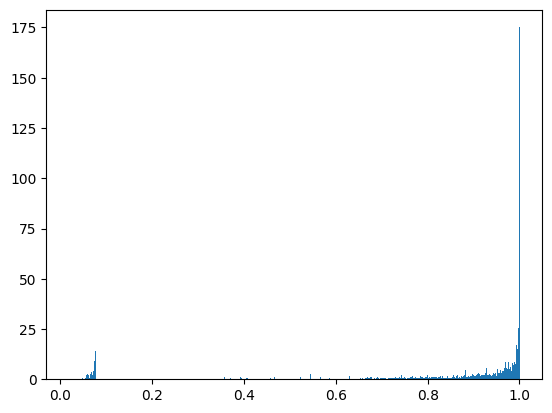

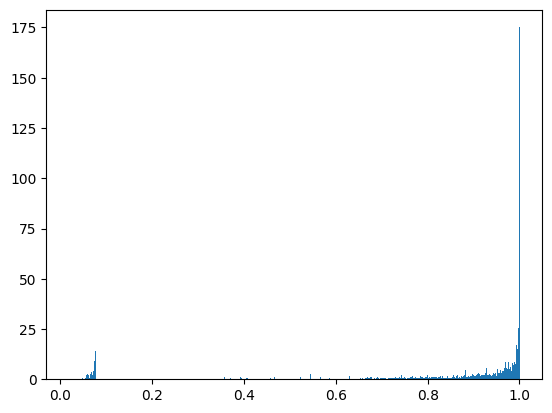

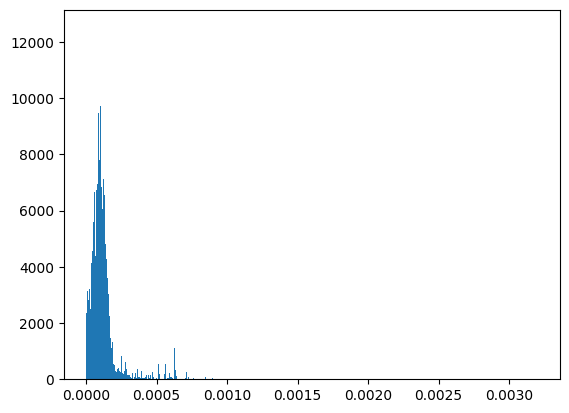

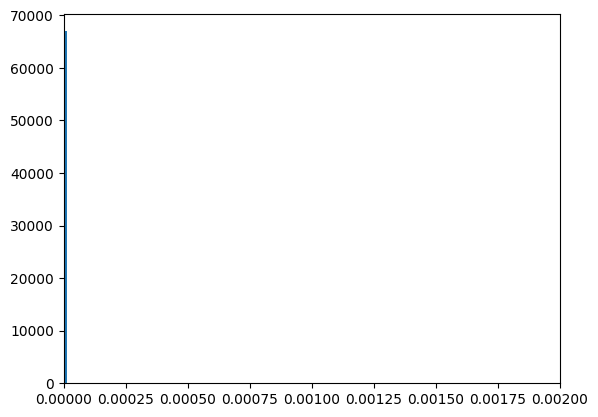

In [5]:
from matplotlib import pyplot as plt
plt.hist(ep_list,bins=5000,density=True)
plt.show()

plt.hist(tp_list,bins=5000,density=True)
plt.show()

plt.hist(error_list,bins=5000,density=True)
plt.show()

plt.hist(sp_dist_list,bins=5000,density=True)
plt.xlim(0,0.002)
plt.show()

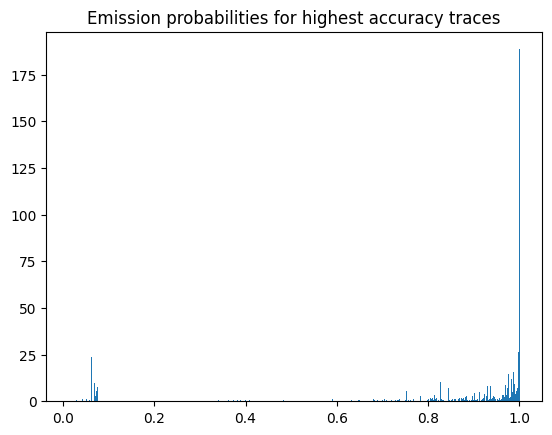

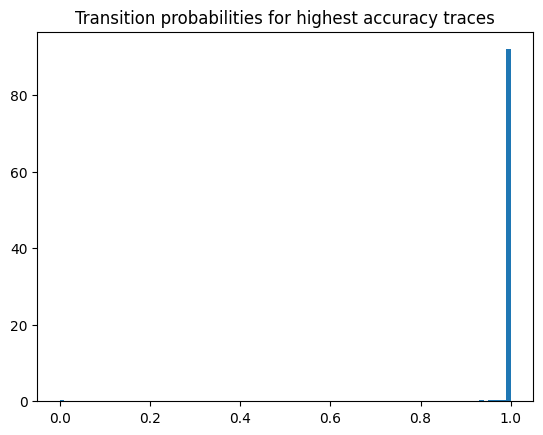

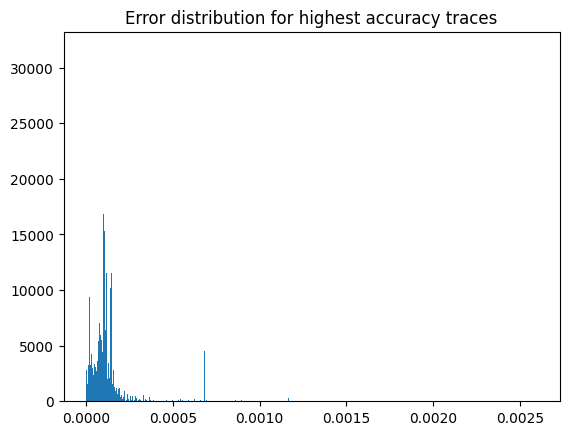

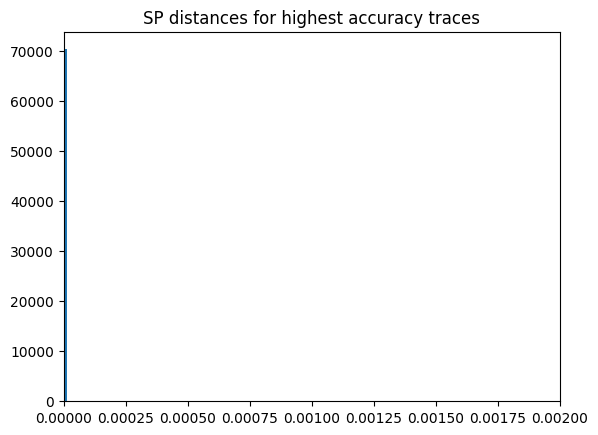

In [7]:
from matplotlib import pyplot as plt
plt.hist(best_ep_list,bins=5000,density=True)
plt.title("Emission probabilities for highest accuracy traces")
plt.show()

plt.hist(best_tp_list,bins=100,density=True)
plt.title("Transition probabilities for highest accuracy traces")
plt.show()

plt.hist(best_error_list,bins=5000,density=True)
plt.title("Error distribution for highest accuracy traces")
plt.show()

plt.hist(best_sp_dist_list,bins=5000,density=True)
plt.title("SP distances for highest accuracy traces")
plt.xlim(0,0.002)
plt.show()

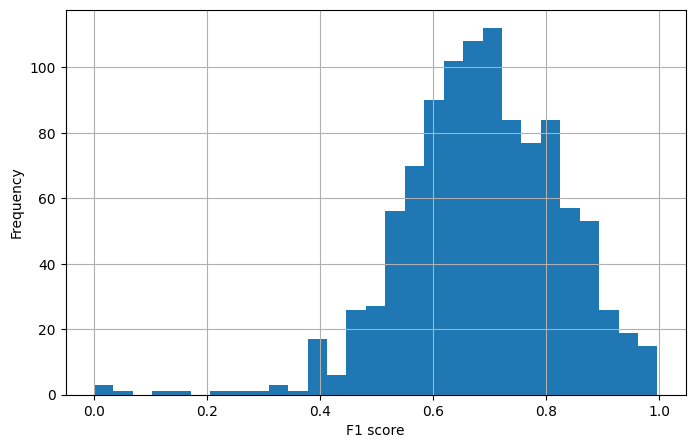

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.hist(total_f1, bins=29)
plt.xlabel("Distribution of F1 scores of different users")  
plt.grid()
plt.ylabel("Frequency")
plt.xlabel("F1 score")
plt.show()